<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1P0PPnVNj1jX1xU3I7XggxZXnEfpN5EWQ" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# **RNA from scratch**


In [1]:
import math;
import random;

import matplotlib.pyplot as plt;
import numpy as np;

## **Funciones de activación**

Empezamos por una clase base de las clases que implementarán las [funciones de activación](https://aew61.github.io/blog/artificial_neural_networks/1_background/1.b_activation_functions_and_derivatives.html).

In [2]:
class ActivationFunction:

      def __init__(self, **kwargs):
          self._args=kwargs;

      def calc(self, x):
          raise NotImplementedError();

      def delta(self, x):
          raise NotImplementedError();

      def name(self):
          raise NotImplementedError();

      def __getitem__(self, key):
          if   isinstance(key,slice):      return [self.calc(x) for x in range(key.start if key.start!=None else 1,key.stop,key.step if key.step!=None else 1)];
          elif isinstance(key,range):      return [self.calc(x) for x in key];
          elif isinstance(key,list):       return [self.calc(x) for x in key];
          elif isinstance(key,tuple):      return [self.calc(x) for x in key];
          elif isinstance(key,int):        return self.calc(key);
          elif isinstance(key,float):      return self.calc(key);
          elif isinstance(key,np.ndarray): return [self.calc(x) for x in key];
          else:                            raise  TypeError();

      def plot(self, arange=np.arange(-10,10,0.01)):
          x=arange;
          y=self.__getitem__(x);
          plt.plot([min(x),max(x)],[0,0],linestyle="dotted");
          plt.plot([0,0],[min(y),max(y)],linestyle="dotted");
          plt.plot(x,y);
          plt.title(self.name());
          plt.xlabel("x");
          plt.ylabel("f(x)");
          plt.show();

Esta clase base nos permite acceder a la función **calc** de diversas formas. Si *f* es un objeto derivado de esta clase, entonces será posible:

```
f[x]             # un valor único, int o float.
f[1:10]          # un slice
f[range(1,10)]   # un rango
f[[1,2,3,4]]     # una lista
f[(1,2,3,4)]     # una tupla
```


### **Función de activación: linear(a,b)**

$
\begin{align}
y=a+b*x
\end{align}
$

Por defecto $a=0$ y $b=1$

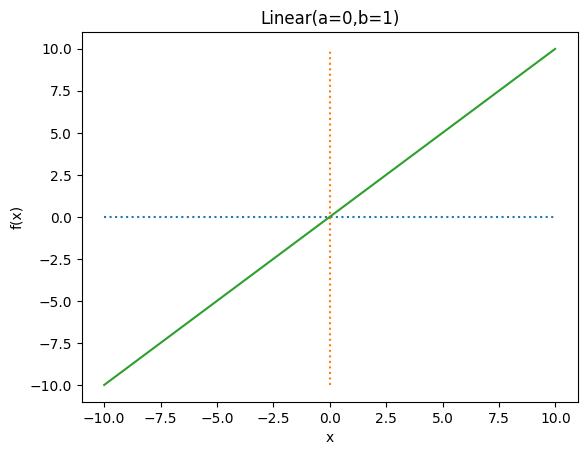

In [3]:
class Linear(ActivationFunction):

      def name(self):
          a=self._args['a'] if 'a' in self._args else 0;
          b=self._args['b'] if 'b' in self._args else 1;
          return f"Linear(a={a},b={b})";

      def calc(self,x):
          a=self._args['a'] if 'a' in self._args else 0;
          b=self._args['b'] if 'b' in self._args else 1;
          return a+x*b;

      def delta(self, x):
          b=self._args['b'] if 'b' in self._args else 1;
          return b;

af=Linear(a=0,b=1);
af.plot();

### **Función de activación: step**

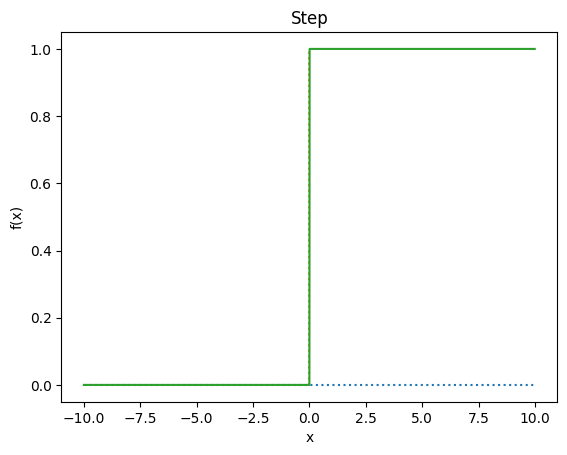

In [4]:
class Step(ActivationFunction):

      def name(self):
          return f"Step";

      def calc(self,x):
          return 0 if x<0 else 1;

      def delta(self, x):
          return float("inf") if x==0 else 0;

af=Step();
af.plot();

### **Función de activación: Sign**

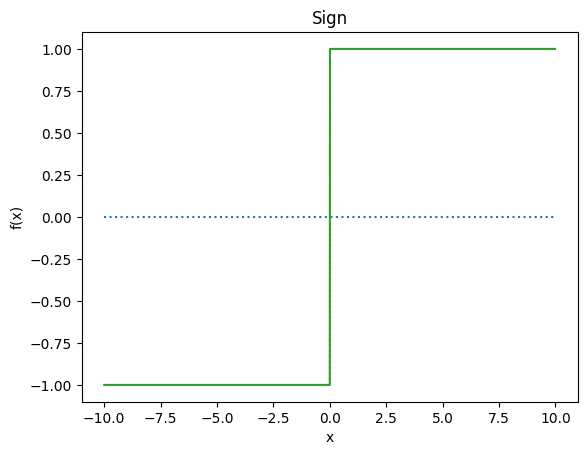

In [5]:
class Sign(ActivationFunction):

      def name(self):
          return f"Sign";

      def calc(self,x):
          return -1 if x<=0 else 1;

      def delta(self, x):
          return float("inf") if x==0 else 0;

af=Sign();
af.plot();

### **Función de activación: Sigmoid**

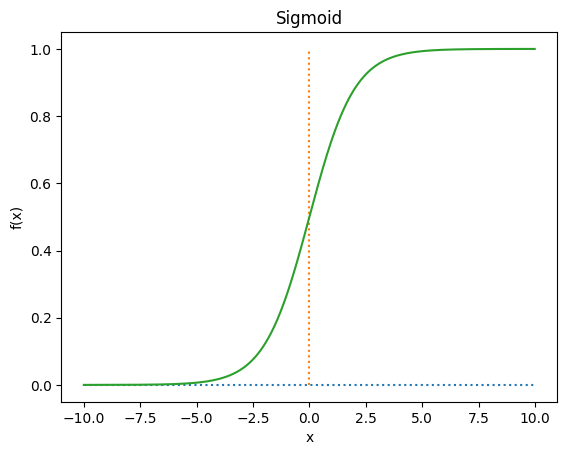

In [6]:
class Sigmoid(ActivationFunction):

      def name(self):
          return f"Sigmoid";

      def calc(self,x):
          return (1/(1+math.exp(-x)));

      def delta(self, x):
          return self.calc(x)*(1-self.calc(x));

af=Sigmoid();
af.plot();

### **Función de activación: Tanh**

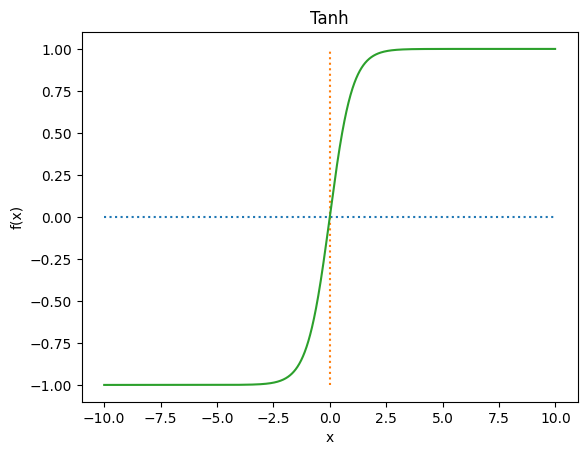

In [7]:
class Tanh(ActivationFunction):

      def name(self):
          return f"Tanh";

      def _g(x):
          return (math.exp(x)/(1+math.exp(x)));

      def calc(self,x):
          return 2*Tanh._g(2*x)-1;

      def delta(self, x):
          return 1-math.pow(self.calc(x),2);

af=Tanh();
af.plot();

### **Función de activación: ReLu(a)**

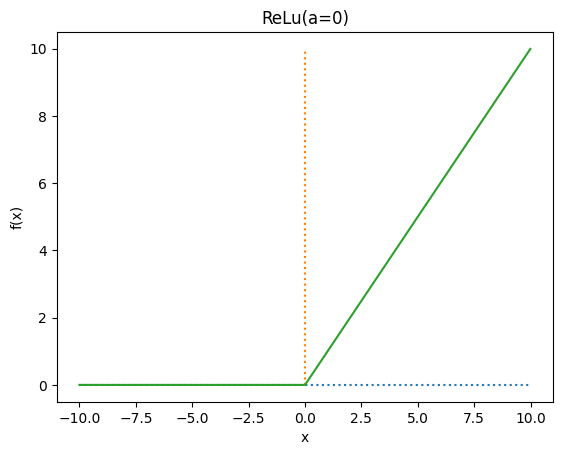

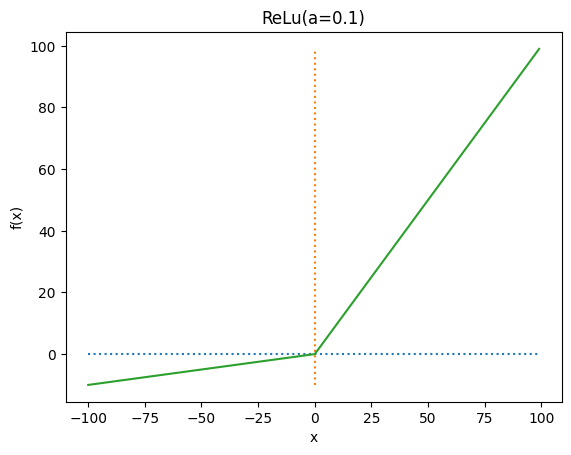

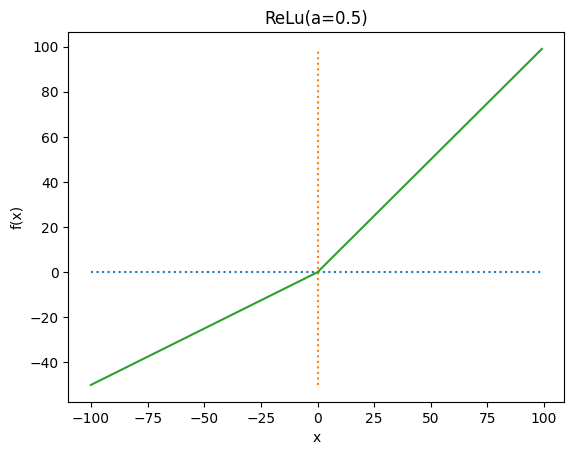

In [8]:
class Relu(ActivationFunction):

      def name(self):
          a=self._args['a'] if 'a' in self._args else 0;
          return f"ReLu(a={a})";

      def calc(self,x):
          a=self._args['a'] if 'a' in self._args else 0;
          return x*a if x<=0 else x;

      def delta(self, x):
          a=self._args['a'] if 'a' in self._args else 0;
          return max(a*x,x);

af=Relu(a=0);
af.plot();

af=Relu(a=0.1);
af.plot(range(-100,100));

af=Relu(a=0.5);
af.plot(range(-100,100));


## **Modelo McCulloch-Pitts con backpropagation**

Es nuestra unidad de procesamiento, el ladrillo básico con el que construir RNA.

Tiene $n$ entradas numéricas, una función de activación y una única salida numérica.

Los pesos se inicializan aleatoriamente, pero podemos pasarle un $seed$ para que siempre sea la misma inicialización.

Observar que $weights[0]$ es el parámetro $bias$.

El aprendizaje se lleva a cabo e el método $train$ mientras que su funcionamiento normal lo lleva a cabo en $do$.

En la fase de backpropagation (cuando se obtiene una salida y se compara con el error para realizar el aprendizaje), la fórmula es la del descenso del gradiente:

$w_i = w_i - α \frac{δMSE(w)}{δw}$

con

$ \frac{δMSE(w)}{δw} = x_i·error \frac{δf(∑_{i=1}^{n}w_i·x_i)}{δw}$

Con $w_i$ el $i$-ésimo peso, $α$ el ratio de aprendizaje, $x_i$ la entrada $i$-ésima, $error$ el error cometido en esta iteración, $y$ la salida del perceptrón en esta iteración y finalmante $δf(y_i)/δw_i$ la derivada en $y_i$ de la función de activación respecto a los pesos.


In [9]:
class Perceptron:

      #------------------------------------------------------------------------
      # Constructor:
      #     nx: tamaño de la entrada (>0)
      #     af: función de activación (instancia)
      #     lr: learning rate
      #     seed es la semilla, si se desea establecer una.
      #------------------------------------------------------------------------
      def __init__(self, nx:int=2, af:ActivationFunction=Sigmoid(), lr=0.001, seed:int=None):
          assert(type(nx)==int and nx>=1);
          assert(seed==None or type(seed)==int);
          assert(isinstance(af,ActivationFunction));
          if seed: random.seed(seed);
          self._nx=nx;
          self._weights=[random.random() for i in range(nx+1)];
          self._weights[0]=(random.random()+1)/2;
          self._af=af;
          self._lr=lr;

      #------------------------------------------------------------------------
      # Una iteración de entrenamiento, con ajuste de pesos (backpropagation)
      #     inputs: lista de datos de entrada (lista de int o de float).
      #     output: valor previsto que debería tener la salida.
      #     -
      #     devuelve el error cometido (calculado-previsto)
      #------------------------------------------------------------------------
      def train(self, inputs:list, output):
          assert(len(inputs )==self._nx and all([type(x) in [int,float] for x in inputs]));
          assert(type(output) in [int,float]);

          ffout=self.do(inputs);
          error=ffout-output;

          self._weights[0]=self._weights[0]-self._lr*error*self._af.delta(ffout);
          for i in range(0,len(inputs)):
              self._weights[1+i] = self._weights[1+i]-self._lr*inputs[i]*error*self._af.delta(ffout);

          return error;

      #------------------------------------------------------------------------
      # Una iteración SIN entrenamiento
      #     *args puede ser una lista, una tupla, o un conjunto e valores.
      #           .do(1,2,3,4)
      #           .do([1,2,3,4])
      #           .do((1,2,3,4))
      #     -
      #     devuelve el valor calculado
      #------------------------------------------------------------------------
      def do(self, *args):

          inputs=None;

          if len(args)==1 and type(args[0]) in [tuple,list]:
             inputs=args[0];
          elif len(args)==self._nx and all([type(x) in [int,float] for x in args]):
             inputs=args;
          else:
             raise RuntimeError();

          assert(inputs and type(inputs) in [tuple,list] and len(inputs)==self._nx);

          value=self._weights[0]*1;
          for i in range(0,len(inputs)): value+=self._weights[1+i]*inputs[i];
          return self._af[value];

      #------------------------------------------------------------------------
      def __str__(self):
          rt="{"+f" {self._nx} / {self._weights} / {self._af.name()} "+"}";
          return rt;



## Vamos a probarlo:

### Contando el número de 1s en una lista de 0 y 1

MSE: 0.00056 en 285 epochs


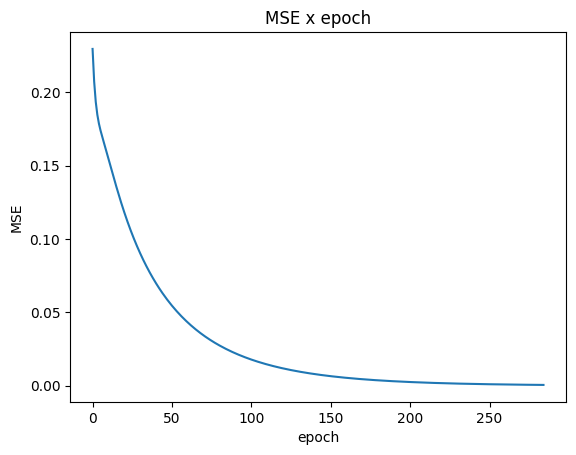

In [10]:
trainset=[
          ((0,0,0), 0),
          ((0,0,1), 1),
          ((0,1,0), 1),
          ((0,1,1), 2),
          ((1,0,0), 1),
          ((1,0,1), 2),
          ((1,1,0), 2),
          ((1,1,1), 3)
         ];

p=Perceptron(3, af=Relu(a=0.001), lr=0.01);
epoch=0;
errors=[];
last=None;
while epoch<1000:
      epoch+=1;
      error=0;
      for v in trainset:
          err=p.train(v[0],v[1]);
          error+=math.pow(err,2.0);
      error=error/len(trainset);
      errors.append(error);
      if last!=None and abs(last-error)<0.00001: break;
      last=error;

print(f"MSE: {round(error,5)} en {epoch} epochs");

x=range(0,epoch);
y=errors;
plt.plot(x,y);
plt.title("MSE x epoch");
plt.xlabel("epoch");
plt.ylabel("MSE");
plt.show();


In [12]:
while True:
      dg=input("Introduce la entrada (a b c): ");
      if not dg: break;
      dg=[int(x) for x in dg.split()];
      r=p.do(dg);
      print(round(r,0));

Introduce la entrada (a b c):  


### Calculando una función booleana (and, or, XOR)

MSE: 0.29558 en 998 epochs


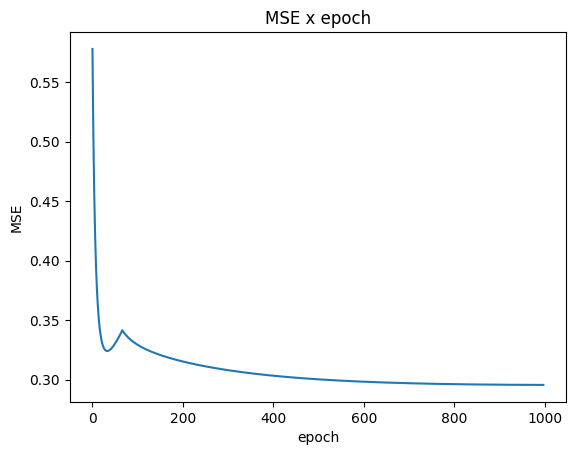

In [13]:
trainset=[
          ((0,0), 0),
          ((0,1), 1),
          ((1,0), 1),
          ((1,1), 0)
         ];

p=Perceptron(2, af=Relu(a=0.1), lr=0.01);
epoch=0;
errors=[];
last=None;
while epoch<50000:
      epoch+=1;
      error=0;
      for v in trainset:
          err=p.train(v[0],v[1]);
          error+=math.pow(err,2.0);
      error=error/len(trainset);
      errors.append(error);
      if last!=None and abs(last-error)<0.000001: break;
      last=error;

print(f"MSE: {round(error,5)} en {epoch} epochs");

x=range(0,epoch);
y=errors;
plt.plot(x,y);
plt.title("MSE x epoch");
plt.xlabel("epoch");
plt.ylabel("MSE");
plt.show();


In [14]:
while True:
      dg=input("Introduce la entrada (a b): ");
      if not dg: break;
      dg=[int(x) for x in dg.split()];
      r=p.do(dg);
      print(round(r,0));

Introduce la entrada (a b):  1 1


0.0


Introduce la entrada (a b):  0 1


-0.0


Introduce la entrada (a b):  


Si has probado con XOR, te habrás encontrado con un problema. El entrenamiento puede que converga, pero no funciona!

## **Explicación iterativa**

Vamos a hacer un juego que muestra porqué esta aproximacion a la RNA no fue suficiente y se desechó en un principio.

In [15]:
# código dependiente de la plataforma (Google Colab)

from google.colab import output;
output.enable_custom_widget_manager();

!pip install -q ipycanvas==0.11
!pip install -q ipyevents

import ipycanvas;
import ipyevents;

from ipycanvas  import Canvas;


ModuleNotFoundError: No module named 'google'

In [ ]:
WIDTH=400;
HEIGHT=300;

COLS=40;
ROWS=30;

color_black="#472D2D";
color_red="#FF9494";
color_blue="#B1B2FF";

def printBoard(canvas, cols, rows, data, data2=None):
    with ipycanvas.hold_canvas(canvas):
         canvas.clear();
         canvas.line_width=1;
         canvas.font='8px serif';
         canvas.fill_style=color_black;
         canvas.stroke_rect(0,0,canvas.width-1,canvas.height-1);

         ix=int(canvas.width/COLS);
         iy=int(canvas.height/ROWS);

         for c in range(COLS):
             for r in range(ROWS):
                 cell=data[c][r];
                 if   cell==0:
                      continue;
                 elif cell==1:
                      canvas.fill_style=color_blue;
                      canvas.fill_rect(c*ix,r*iy,ix,iy);
                 elif cell==2:
                      canvas.fill_style=color_red;
                      canvas.fill_rect(c*ix,r*iy,ix,iy);

                 if data2:
                    cell=data2[c][r];
                    if   cell==0:
                         continue;
                    elif cell==1:
                         canvas.fill_style="blue";
                         canvas.fill_rect(c*ix,r*iy,ix,iy);
                    elif cell==2:
                         canvas.fill_style="red";
                         canvas.fill_rect(c*ix,r*iy,ix,iy);



In [ ]:
board = [[0 for y in range(ROWS)] for x in range(COLS)];

def handle_mouse_down(x,y):
    global board;
    ix=int(canvas.width/COLS);
    iy=int(canvas.height/ROWS);
    col=x//ix;
    row=y//iy;
    if    board[col][row]==0: board[col][row]=1;
    elif  board[col][row]==1: board[col][row]=2;
    else:                     board[col][row]=0;
    printBoard(canvas, COLS, ROWS, board);

canvas=Canvas(width=WIDTH, height=HEIGHT);
display(canvas);

printBoard(canvas, COLS, ROWS, board);

canvas.on_mouse_down(handle_mouse_down);


Canvas(height=300, width=400)

MSE: 0.03327 en 5267 epochs


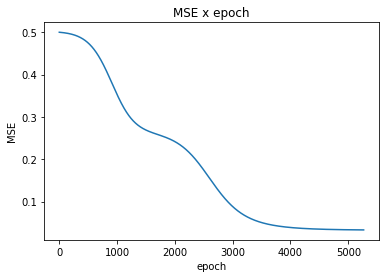

In [ ]:
trainset=[];

for c in range(COLS):
    for r in range(ROWS):
        if board[c][r]!=0:
           v=board[c][r];
           trainset.append( ((c,r),v-1) );

p=Perceptron(2, af=Sigmoid(), lr=0.00001);
epoch=0;
errors=[];
last=None;
while epoch<50000:
      epoch+=1;
      error=0;
      for d in trainset:
          err=p.train(d[0],d[1]);
          error+=math.pow(err,2.0);
      error=error/len(trainset);
      errors.append(error);
      if last!=None and abs(last-error)<0.000001: break;
      last=error;

print(f"MSE: {round(error,5)} en {epoch} epochs");

x=range(0,epoch);
y=errors;
plt.plot(x,y);
plt.title("MSE x epoch");
plt.xlabel("epoch");
plt.ylabel("MSE");
plt.show();


In [ ]:
predicted_board = [[0 for y in range(ROWS)] for x in range(COLS)];

for c in range(COLS):
    for r in range(ROWS):
        predicted_board[c][r]=int(round(p.do([c,r])+1));

canvas=Canvas(width=WIDTH, height=HEIGHT);
display(canvas);

printBoard(canvas, COLS, ROWS, predicted_board, board);


Canvas(height=300, width=400)

Probar más en: https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=1,1&seed=0.44886&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false
